In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
678   -0.202890
679   -0.208760
680   -0.158770
681   -0.044196
682    0.143450
683    0.209620
684    0.145020
685   -0.073161
686   -0.170330
687   -0.170350
688   -0.084327
689    0.003465
690    0.113130
691    0.056119
692    0.011284
693   -0.050664
694    0.034800
695    0.017427
696   -0.019294
697    0.021388
698   -0.028952
699    0.038371
700   -0.045308
701    0.046826
702   -0.042584
703   -0.030396
704   -0.001803
705    0.018636
706   -0.016862
707    0.022332
Name: f0, Length: 708, d

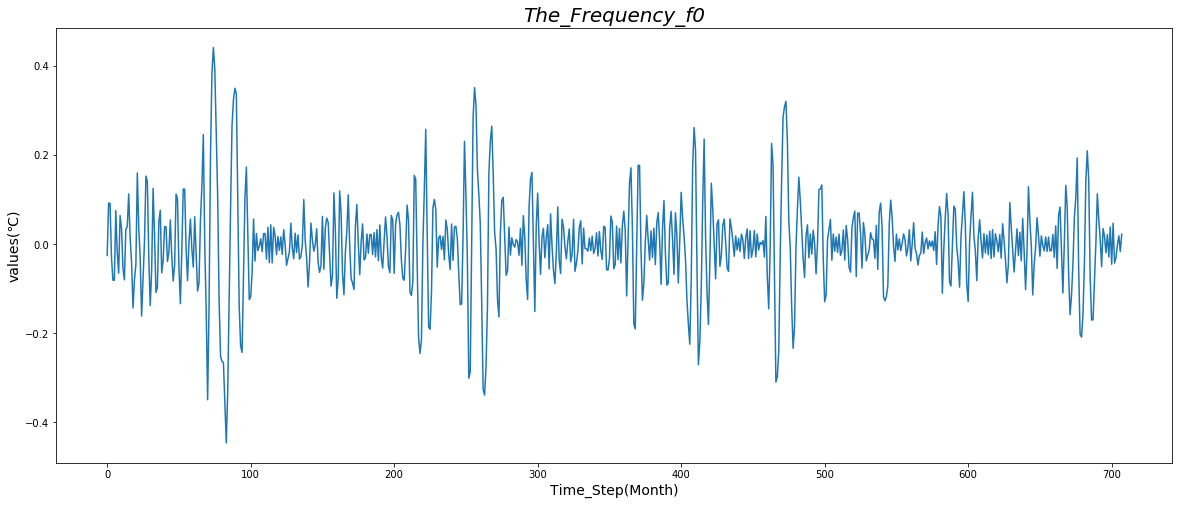

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 13s - loss: 0.0111
Epoch 2/200
 - 3s - loss: 0.0109
Epoch 3/200
 - 3s - loss: 0.0109
Epoch 4/200
 - 3s - loss: 0.0109
Epoch 5/200
 - 4s - loss: 0.0110
Epoch 6/200
 - 3s - loss: 0.0109
Epoch 7/200
 - 3s - loss: 0.0109
Epoch 8/200
 - 3s - loss: 0.0109
Epoch 9/200
 - 3s - loss: 0.0109
Epoch 10/200
 - 3s - loss: 0.0108
Epoch 11/200
 - 3s - loss: 0.0107
Epoch 12/200
 - 3s - loss: 0.0104
Epoch 13/200
 - 3s - loss: 0.0104
Epoch 14/200
 - 3s - loss: 0.0102
Epoch 15/200
 - 3s - loss: 0.0097
Epoch 16/200
 - 3s - loss: 0.0105
Epoch 17/200
 - 3s - loss: 0.0099
Epoch 18/200
 - 3s - loss: 0.0099
Epoch 19/200
 - 3s - loss: 0.0094
Epoch 20/200
 - 3s - loss: 0.0092
Epoch 21/200
 - 3s - loss: 0.0089
Epoch 22/200
 - 3s - loss: 0.0087
Epoch 23/200
 - 3s - loss: 0.0084
Epoch 24/200
 - 3s - loss: 0.0084
Epoch 25/200
 - 3s - loss: 0.0085
Epoch 26/200
 - 3s - loss: 0.0082
Epoch 27/200
 - 3s - loss: 0.0081
Epoch 28/200
 - 3s - loss: 0.0080
Epoch 29

(56, 12)


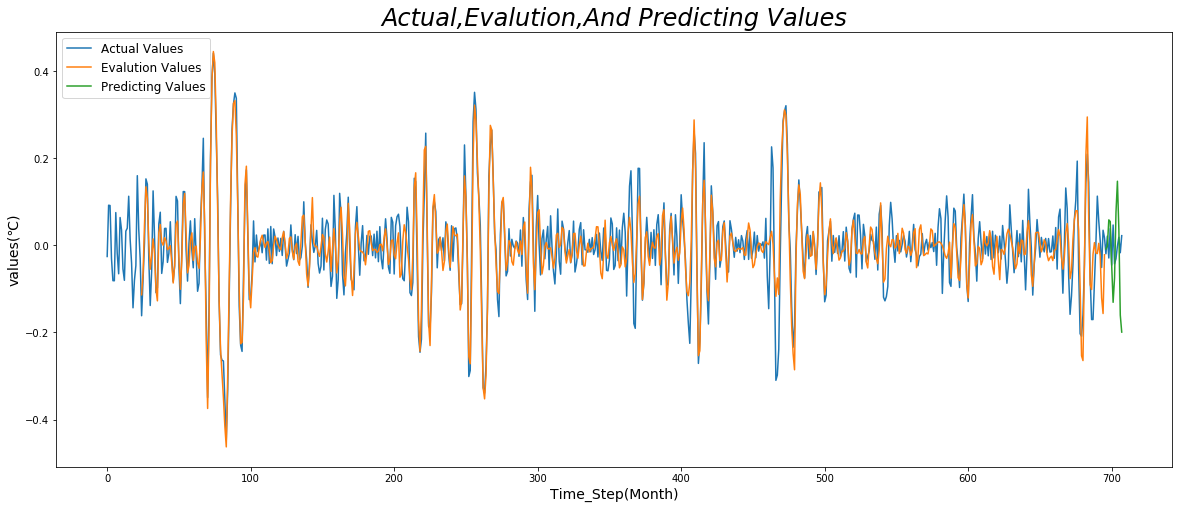

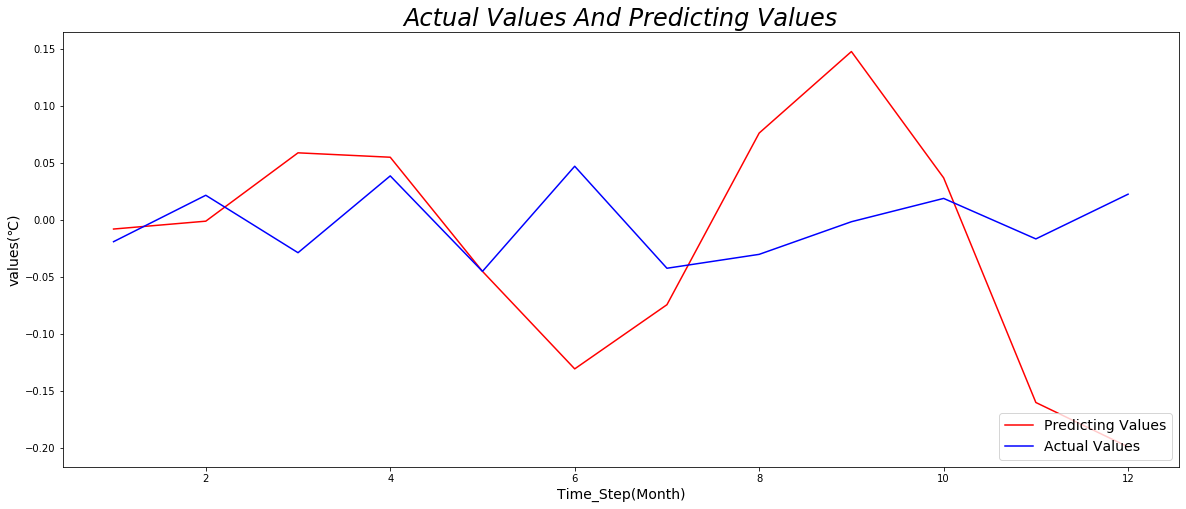

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
678    0.244560
679    0.413660
680    0.537540
681    0.611040
682    0.629310
683    0.589520
684    0.499680
685    0.379930
686    0.252980
687    0.139920
688    0.049156
689   -0.037781
690   -0.143730
691   -0.282870
692   -0.436790
693   -0.578930
694   -0.676550
695   -0.682130
696   -0.581730
697   -0.373990
698   -0.092222
699    0.153170
700    0.329120
701    0.507090
702    0.642710
703    0.651090
704    0.517000
705    0.269650
706   -0.037233
707   -0.328340
Name: f1, Length: 708, d

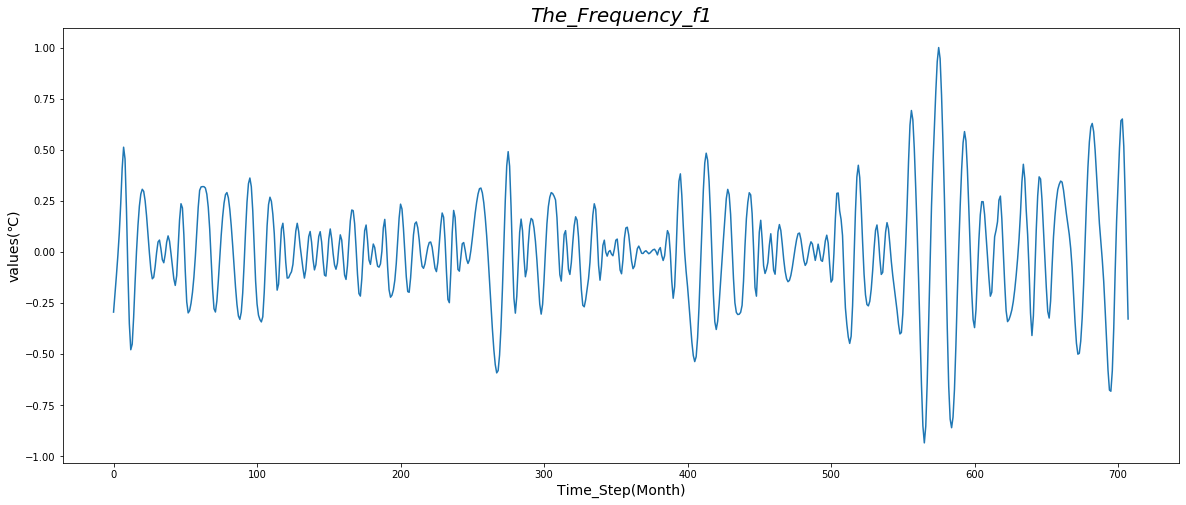

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 15s - loss: 0.0597
Epoch 2/200
 - 3s - loss: 0.0553
Epoch 3/200
 - 3s - loss: 0.0498
Epoch 4/200
 - 3s - loss: 0.0434
Epoch 5/200
 - 3s - loss: 0.0411
Epoch 6/200
 - 3s - loss: 0.0371
Epoch 7/200
 - 3s - loss: 0.0364
Epoch 8/200
 - 3s - loss: 0.0346
Epoch 9/200
 - 3s - loss: 0.0331
Epoch 10/200
 - 3s - loss: 0.0319
Epoch 11/200
 - 3s - loss: 0.0305
Epoch 12/200
 - 3s - loss: 0.0316
Epoch 13/200
 - 3s - loss: 0.0288
Epoch 14/200
 - 3s - loss: 0.0280
Epoch 15/200
 - 3s - loss: 0.0267
Epoch 16/200
 - 3s - loss: 0.0270
Epoch 17/200
 - 4s - loss: 0.0266
Epoch 18/200
 - 3s - loss: 0.0261
Epoch 19/200
 - 3s - loss: 0.0267
Epoch 20/200
 - 3s - loss: 0.0267
Epoch 21/200
 - 3s - loss: 0.0253
Epoch 22/200
 - 3s - loss: 0.0232
Epoch 23/200
 - 3s - loss: 0.0240
Epoch 24/200
 - 3s - loss: 0.0229
Epoch 25/200
 - 3s - loss: 0.0229
Epoch 26/200
 - 3s - loss: 0.0224
Epoch 27/200
 - 3s - loss: 0.0231
Epoch 28/200
 - 3s - loss: 0.0211
Epoch 29/200
 - 3s - loss: 0.0206
Epoch 30/200
 - 3s - l

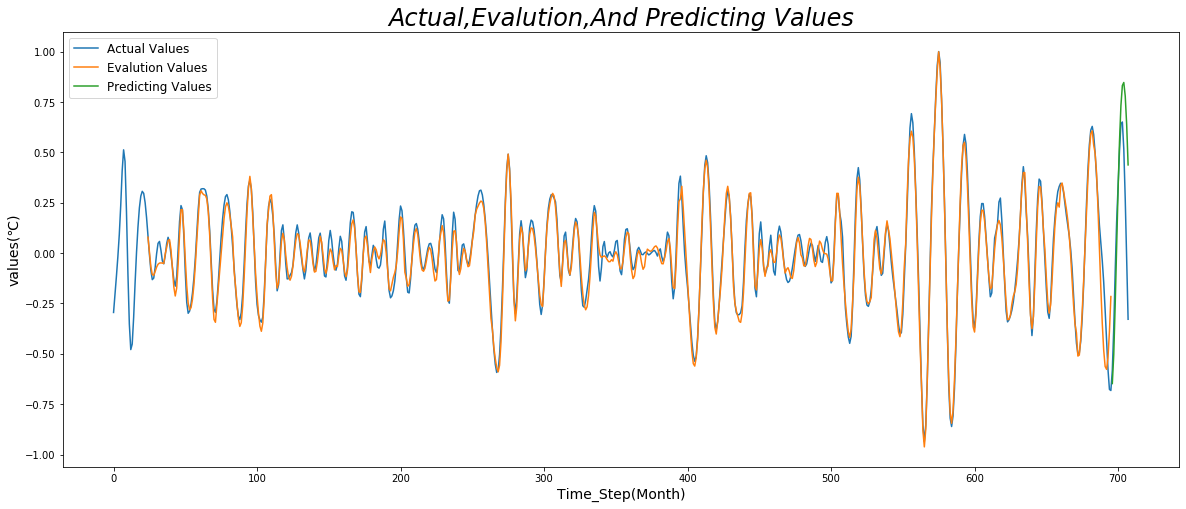

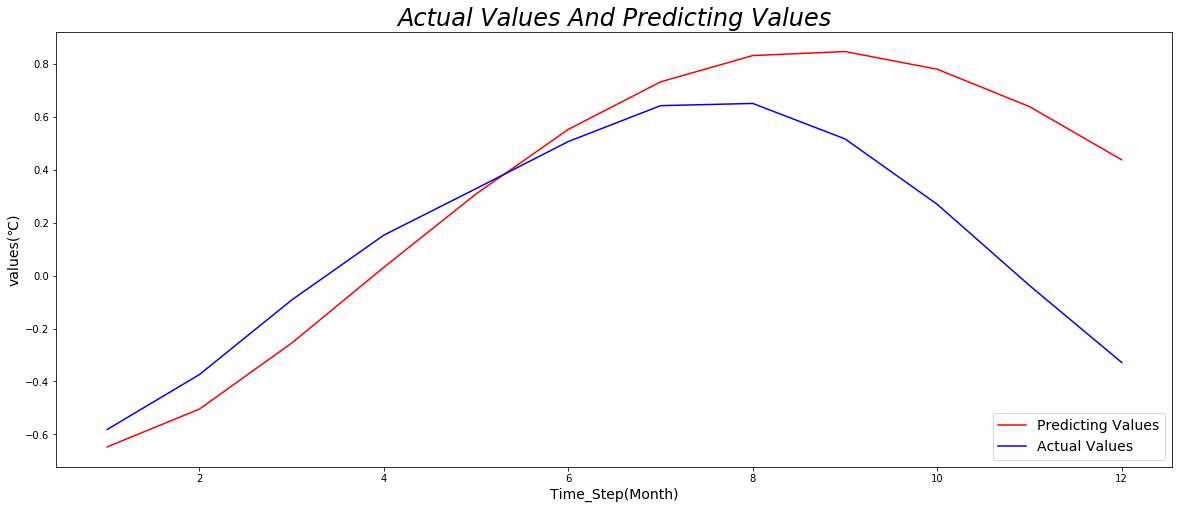

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
678    0.289740
679    0.353160
680    0.403750
681    0.437530
682    0.450570
683    0.440010
684    0.407250
685    0.355090
686    0.286450
687    0.204210
688    0.111270
689    0.010530
690   -0.095109
691   -0.202750
692   -0.309500
693   -0.412450
694   -0.508710
695   -0.595380
696   -0.669730
697   -0.729690
698   -0.773390
699   -0.798910
700   -0.804370
701   -0.787890
702   -0.747490
703   -0.681200
704   -0.588300
705   -0.473200
706   -0.341580
707   -0.199120
Name: f2, Length: 708, d

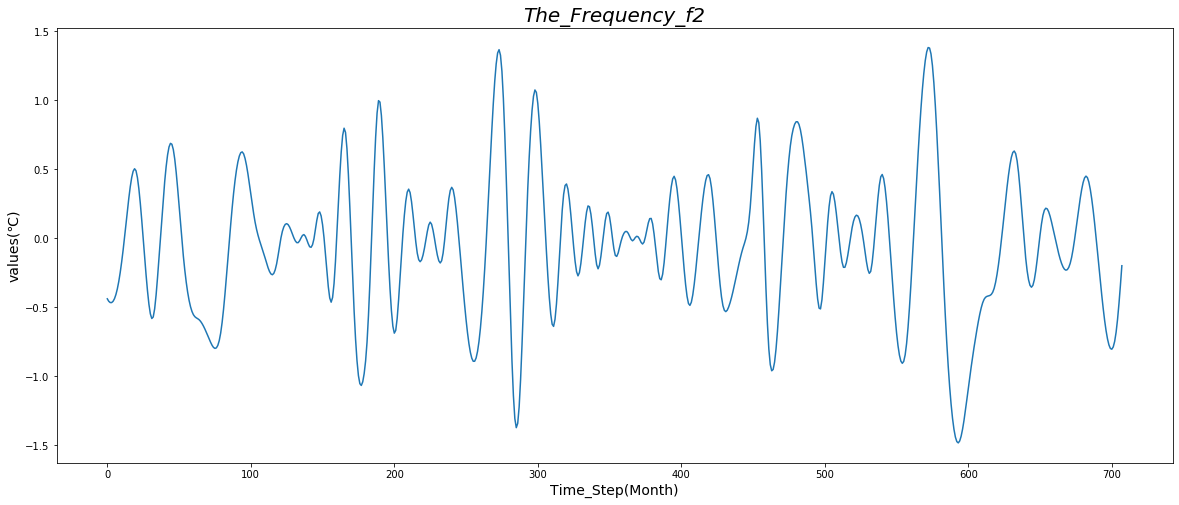

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 15s - loss: 0.2539
Epoch 2/200
 - 3s - loss: 0.2364
Epoch 3/200
 - 3s - loss: 0.2165
Epoch 4/200
 - 3s - loss: 0.1812
Epoch 5/200
 - 3s - loss: 0.1463
Epoch 6/200
 - 3s - loss: 0.1273
Epoch 7/200
 - 3s - loss: 0.1071
Epoch 8/200
 - 3s - loss: 0.0974
Epoch 9/200
 - 3s - loss: 0.0945
Epoch 10/200
 - 3s - loss: 0.0832
Epoch 11/200
 - 3s - loss: 0.0804
Epoch 12/200
 - 3s - loss: 0.0828
Epoch 13/200
 - 3s - loss: 0.0749
Epoch 14/200
 - 3s - loss: 0.0655
Epoch 15/200
 - 3s - loss: 0.0635
Epoch 16/200
 - 3s - loss: 0.0593
Epoch 17/200
 - 3s - loss: 0.0586
Epoch 18/200
 - 3s - loss: 0.0631
Epoch 19/200
 - 3s - loss: 0.0642
Epoch 20/200
 - 3s - loss: 0.0532
Epoch 21/200
 - 3s - loss: 0.0531
Epoch 22/200
 - 3s - loss: 0.0584
Epoch 23/200
 - 3s - loss: 0.0497
Epoch 24/200
 - 3s - loss: 0.0478
Epoch 25/200
 - 3s - loss: 0.0490
Epoch 26/200
 - 3s - loss: 0.0469
Epoch 27/200
 - 3s - loss: 0.0460
Epoch 28/200
 - 3s - loss: 0.0451
Epoch 29/200
 - 3s - loss: 0.0443
Epoch 30/200
 - 3s - l

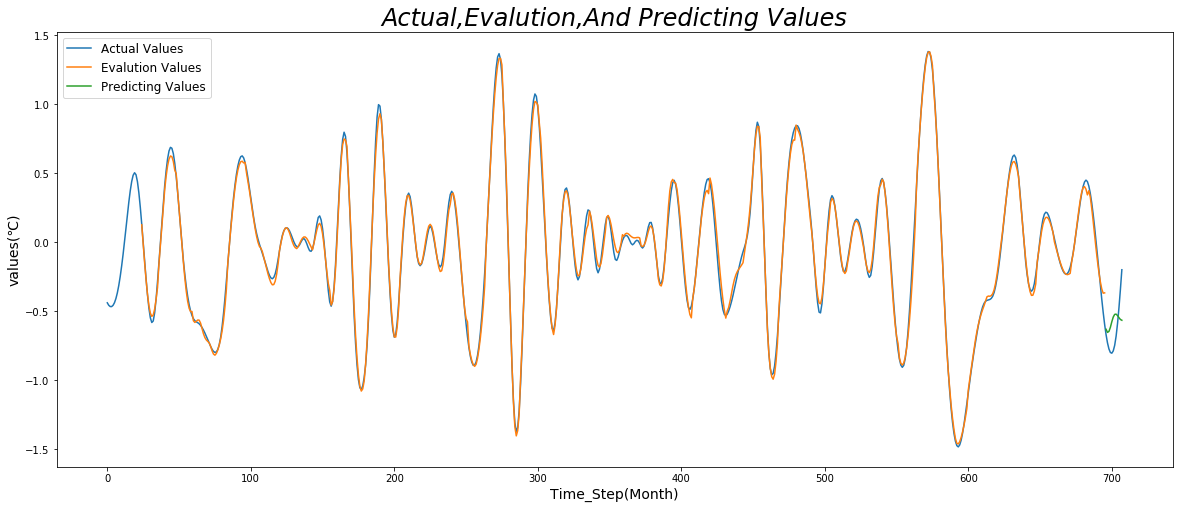

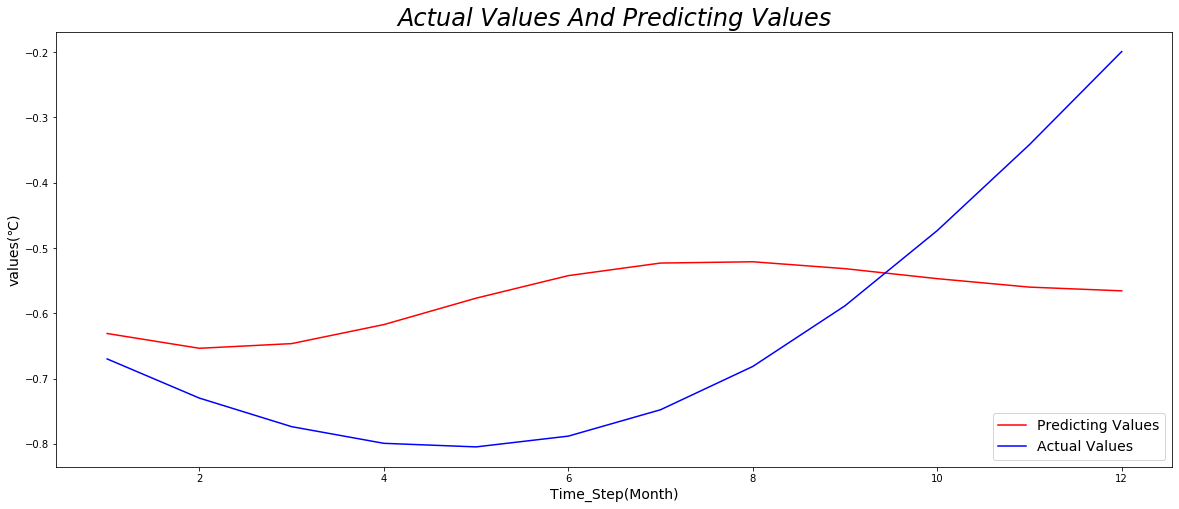

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
678   -0.185880
679   -0.205280
680   -0.222370
681   -0.236780
682   -0.248170
683   -0.256340
684   -0.261390
685   -0.263480
686   -0.262780
687   -0.259440
688   -0.253620
689   -0.245470
690   -0.235150
691   -0.222820
692   -0.208650
693   -0.192820
694   -0.175480
695   -0.156810
696   -0.136970
697   -0.116130
698   -0.094459
699   -0.072128
700   -0.049296
701   -0.026130
702   -0.002868
703    0.020229
704    0.042903
705    0.064891
706    0.085936
707    0.105780
Name: f3, Length: 708, d

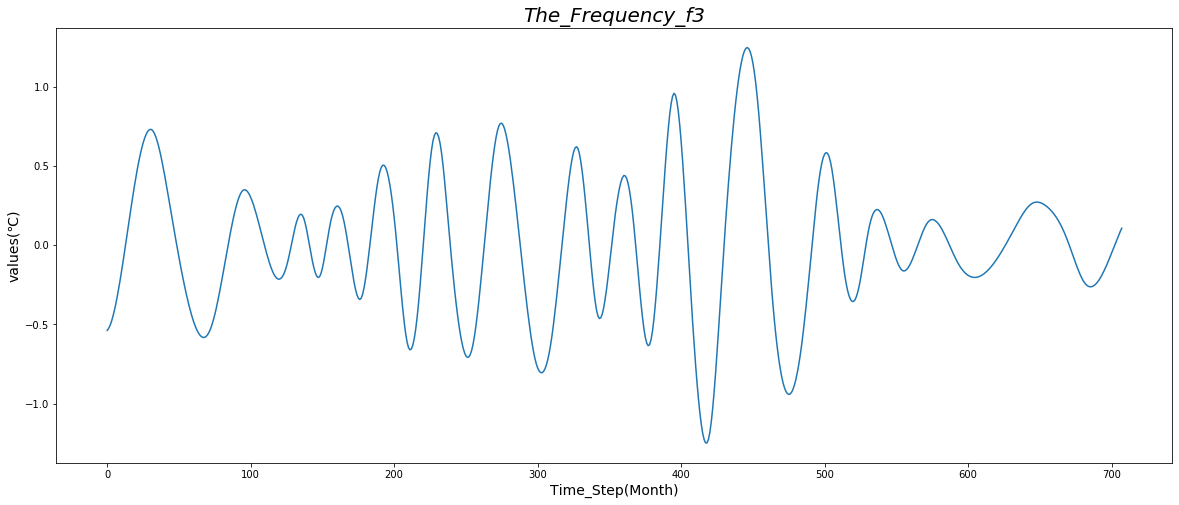

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 17s - loss: 0.1632
Epoch 2/200
 - 3s - loss: 0.1185
Epoch 3/200
 - 3s - loss: 0.0878
Epoch 4/200
 - 3s - loss: 0.0587
Epoch 5/200
 - 3s - loss: 0.0428
Epoch 6/200
 - 3s - loss: 0.0449
Epoch 7/200
 - 3s - loss: 0.0277
Epoch 8/200
 - 3s - loss: 0.0244
Epoch 9/200
 - 3s - loss: 0.0309
Epoch 10/200
 - 3s - loss: 0.0222
Epoch 11/200
 - 3s - loss: 0.0233
Epoch 12/200
 - 3s - loss: 0.0155
Epoch 13/200
 - 3s - loss: 0.0142
Epoch 14/200
 - 3s - loss: 0.0163
Epoch 15/200
 - 3s - loss: 0.0135
Epoch 16/200
 - 3s - loss: 0.0133
Epoch 17/200
 - 3s - loss: 0.0110
Epoch 18/200
 - 3s - loss: 0.0111
Epoch 19/200
 - 3s - loss: 0.0101
Epoch 20/200
 - 3s - loss: 0.0107
Epoch 21/200
 - 3s - loss: 0.0133
Epoch 22/200
 - 3s - loss: 0.0126
Epoch 23/200
 - 4s - loss: 0.0121
Epoch 24/200
 - 3s - loss: 0.0110
Epoch 25/200
 - 3s - loss: 0.0084
Epoch 26/200
 - 3s - loss: 0.0087
Epoch 27/200
 - 3s - loss: 0.0099
Epoch 28/200
 - 3s - loss: 0.0085
Epoch 29/200
 - 3s - loss: 0.0094
Epoch 30/200
 - 3s - l

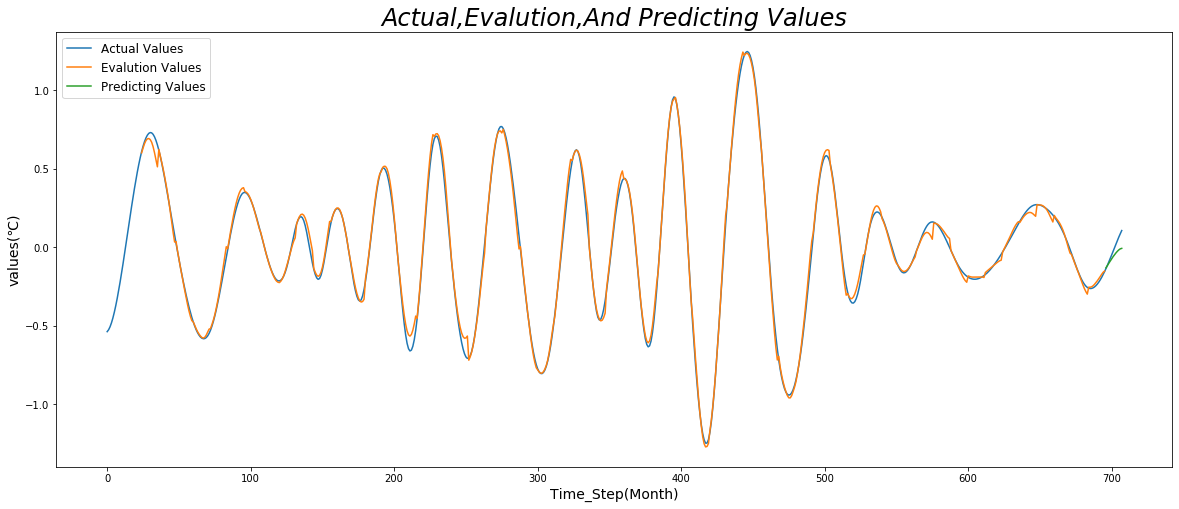

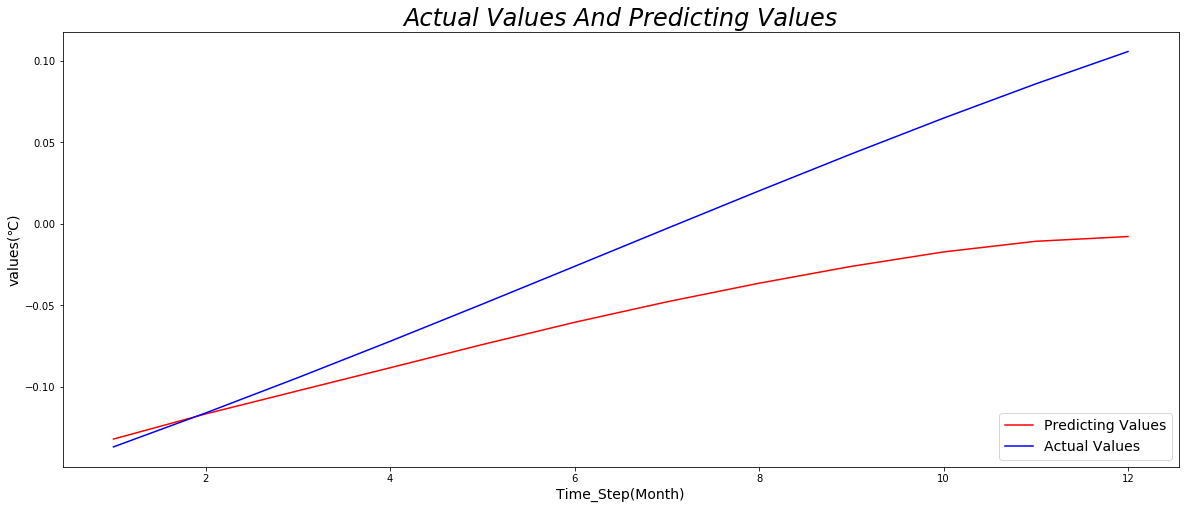

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
678    0.218490
679    0.210860
680    0.203030
681    0.194980
682    0.186740
683    0.178290
684    0.169650
685    0.160820
686    0.151790
687    0.142550
688    0.133110
689    0.123430
690    0.113530
691    0.103400
692    0.093041
693    0.082458
694    0.071655
695    0.060635
696    0.049402
697    0.037958
698    0.026307
699    0.014453
700    0.002398
701   -0.009854
702   -0.022300
703   -0.034936
704   -0.047759
705   -0.060765
706   -0.073953
707   -0.087317
Name: f4, Length: 708, d

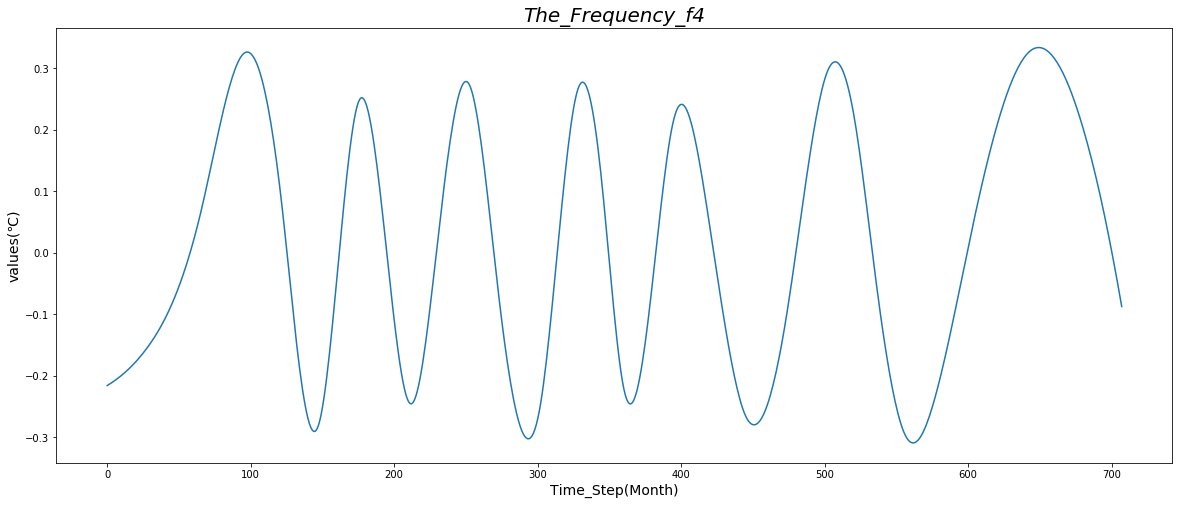

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 18s - loss: 0.0352
Epoch 2/200
 - 3s - loss: 0.0132
Epoch 3/200
 - 3s - loss: 0.0062
Epoch 4/200
 - 3s - loss: 0.0037
Epoch 5/200
 - 3s - loss: 0.0028
Epoch 6/200
 - 3s - loss: 0.0018
Epoch 7/200
 - 3s - loss: 0.0012
Epoch 8/200
 - 3s - loss: 0.0014
Epoch 9/200
 - 3s - loss: 0.0015
Epoch 10/200
 - 3s - loss: 8.8277e-04
Epoch 11/200
 - 3s - loss: 7.4727e-04
Epoch 12/200
 - 3s - loss: 9.9801e-04
Epoch 13/200
 - 3s - loss: 0.0011
Epoch 14/200
 - 3s - loss: 9.8407e-04
Epoch 15/200
 - 3s - loss: 9.5698e-04
Epoch 16/200
 - 3s - loss: 5.2531e-04
Epoch 17/200
 - 3s - loss: 6.1212e-04
Epoch 18/200
 - 3s - loss: 5.3714e-04
Epoch 19/200
 - 3s - loss: 7.0314e-04
Epoch 20/200
 - 3s - loss: 7.0093e-04
Epoch 21/200
 - 3s - loss: 8.5551e-04
Epoch 22/200
 - 3s - loss: 6.1470e-04
Epoch 23/200
 - 3s - loss: 6.0357e-04
Epoch 24/200
 - 3s - loss: 5.6595e-04
Epoch 25/200
 - 3s - loss: 6.5714e-04
Epoch 26/200
 - 3s - loss: 5.7335e-04
Epoch 27/200
 - 3s - loss: 4.2358e-04
Epoch 28/200
 - 3s - l

(56, 12)


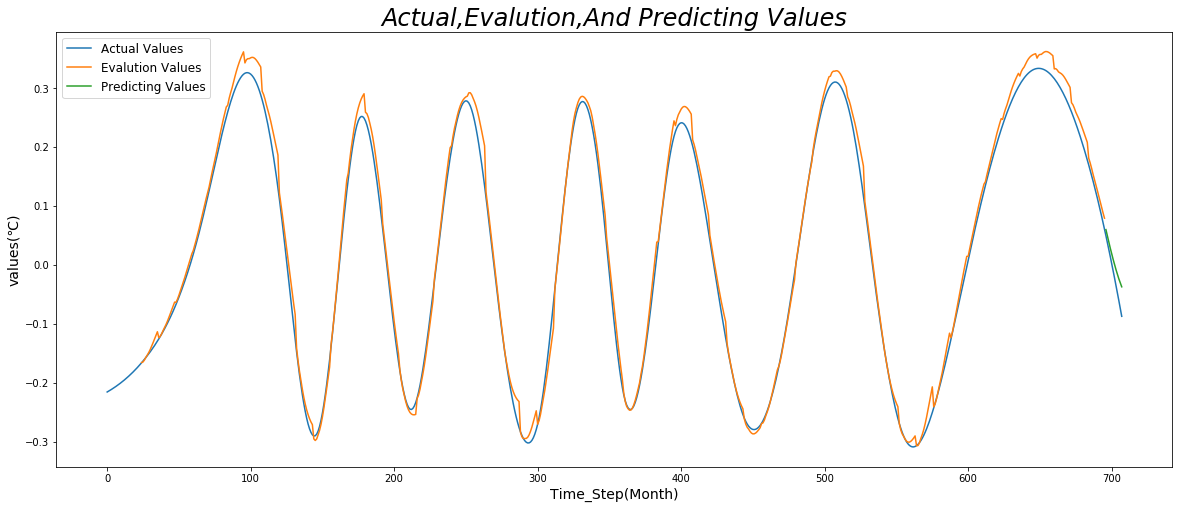

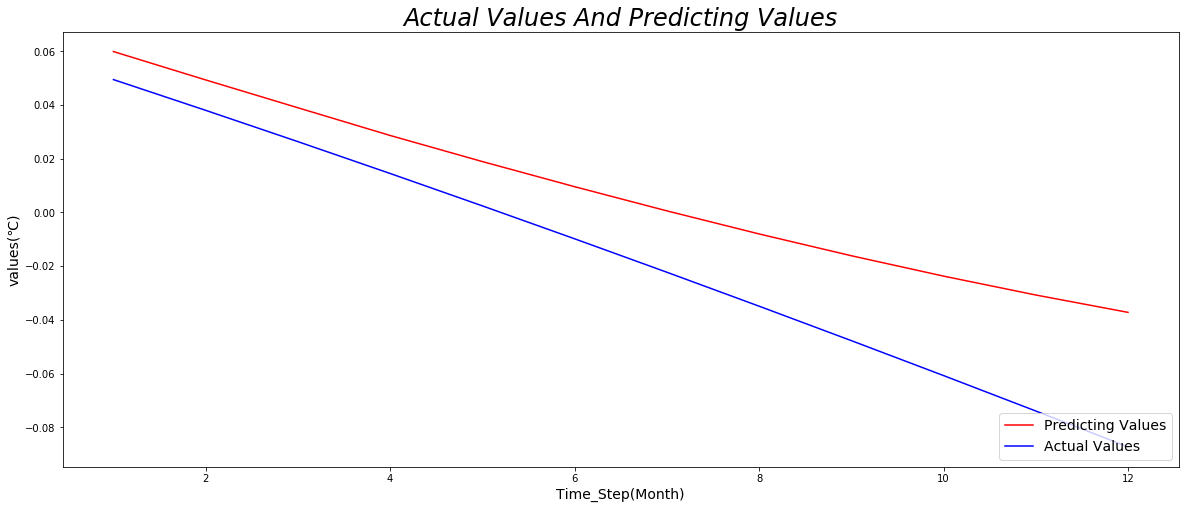

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
678   -0.165780
679   -0.165530
680   -0.165200
681   -0.164790
682   -0.164300
683   -0.163730
684   -0.163080
685   -0.162360
686   -0.161560
687   -0.160680
688   -0.159730
689   -0.158710
690   -0.157610
691   -0.156440
692   -0.155200
693   -0.153890
694   -0.152510
695   -0.151060
696   -0.149550
697   -0.147960
698   -0.146310
699   -0.144590
700   -0.142810
701   -0.140960
702   -0.139050
703   -0.137070
704   -0.135030
705   -0.132930
706   -0.130780
707   -0.128560
Name: f5, Length: 708, d

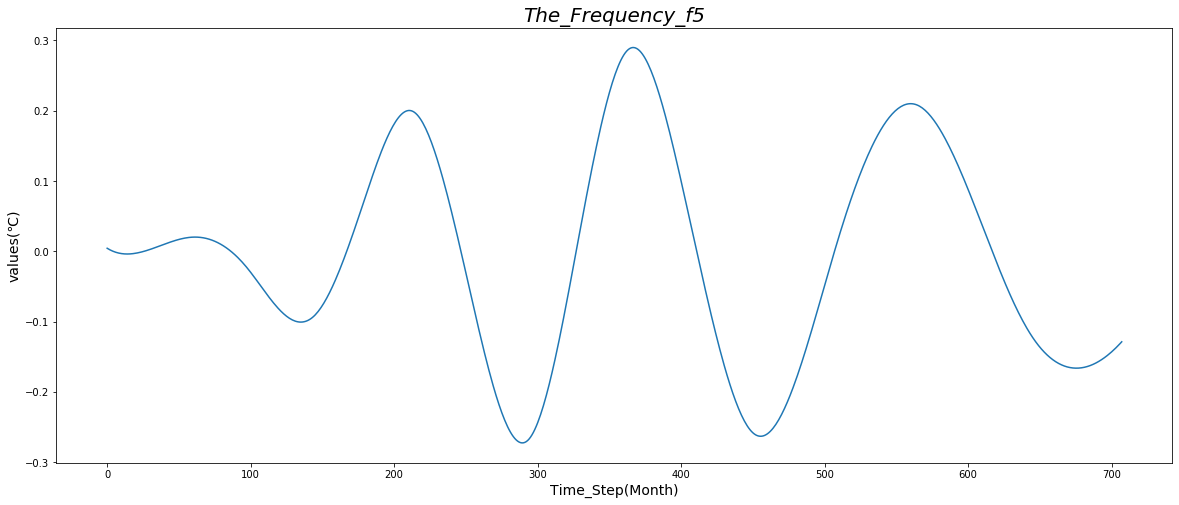

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 21s - loss: 0.0144
Epoch 2/200
 - 4s - loss: 0.0068
Epoch 3/200
 - 4s - loss: 0.0018
Epoch 4/200
 - 3s - loss: 6.6341e-04
Epoch 5/200
 - 3s - loss: 2.8930e-04
Epoch 6/200
 - 3s - loss: 1.6895e-04
Epoch 7/200
 - 3s - loss: 1.3461e-04
Epoch 8/200
 - 3s - loss: 1.1330e-04
Epoch 9/200
 - 4s - loss: 1.1902e-04
Epoch 10/200
 - 3s - loss: 7.0265e-05
Epoch 11/200
 - 3s - loss: 7.0608e-05
Epoch 12/200
 - 3s - loss: 8.3548e-05
Epoch 13/200
 - 3s - loss: 7.4749e-05
Epoch 14/200
 - 3s - loss: 7.7375e-05
Epoch 15/200
 - 3s - loss: 5.9366e-05
Epoch 16/200
 - 3s - loss: 5.4114e-05
Epoch 17/200
 - 3s - loss: 7.0818e-05
Epoch 18/200
 - 3s - loss: 6.9596e-05
Epoch 19/200
 - 3s - loss: 9.2349e-05
Epoch 20/200
 - 3s - loss: 6.7225e-05
Epoch 21/200
 - 3s - loss: 4.8659e-05
Epoch 22/200
 - 3s - loss: 5.4079e-05
Epoch 23/200
 - 3s - loss: 7.5447e-05
Epoch 24/200
 - 3s - loss: 5.1198e-05
Epoch 25/200
 - 3s - loss: 6.8878e-05
Epoch 26/200
 - 3s - loss: 6.4660e-05
Epoch 27/200
 - 3s - loss: 6.414

(56, 12)


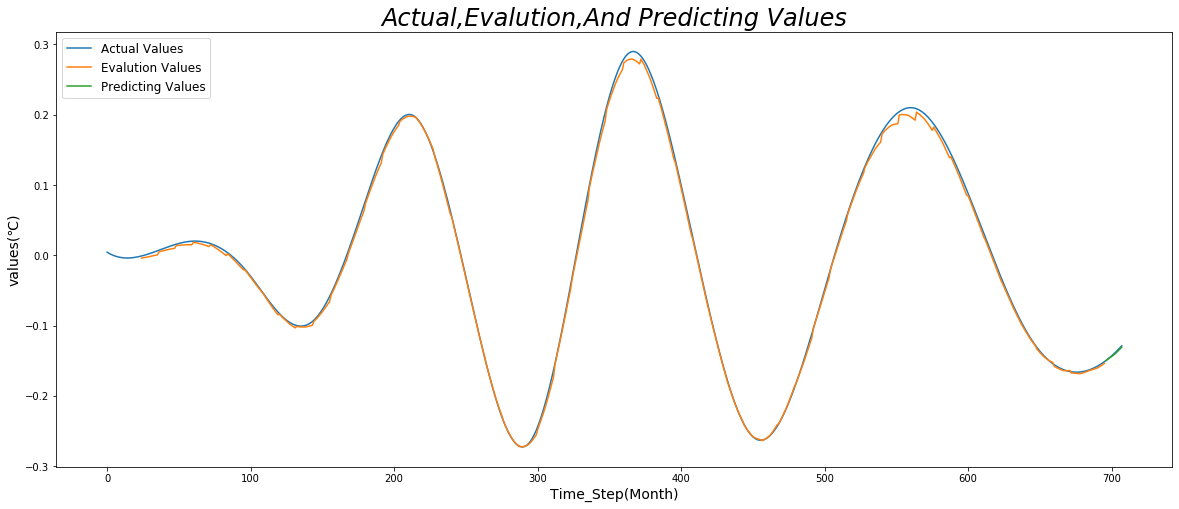

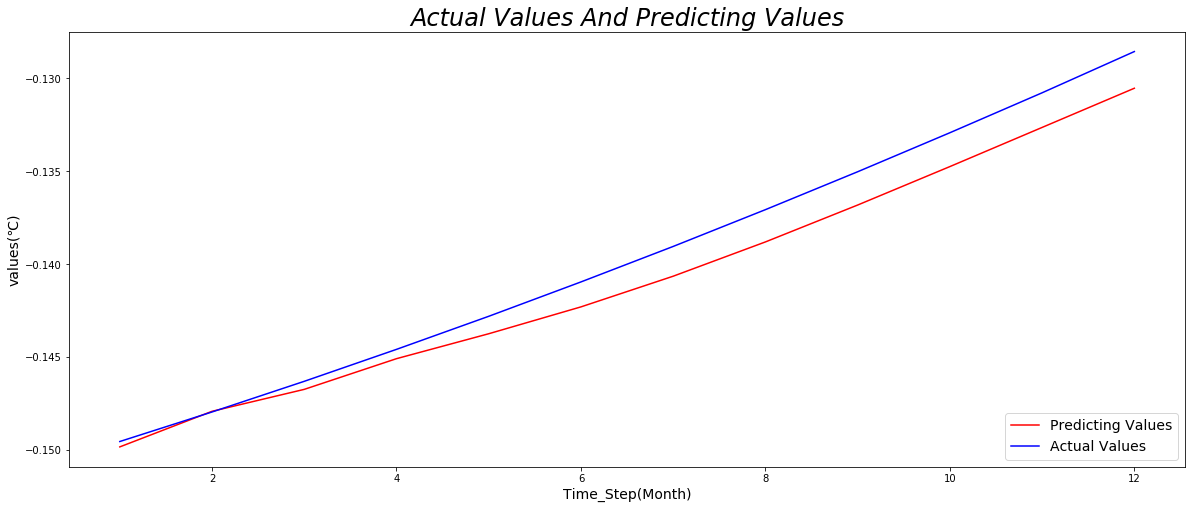

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
678   -0.21996
679   -0.21991
680   -0.21983
681   -0.21972
682   -0.21958
683   -0.21940
684   -0.21920
685   -0.21897
686   -0.21871
687   -0.21842
688   -0.21810
689   -0.21775
690   -0.21738
691   -0.21698
692   -0.21655
693   -0.21609
694   -0.21561
695   -0.21510
696   -0.21457
697   -0.21401
698   -0.21343
699   -0.21283
700   -0.21220
701   -0.21154
702   -0.21087
703   -0.21017
704   -0.20945
705   -0.20870
706   -0.20794
707   -0.20715
Name: f6, Length: 708, dtype: float64
(708,)


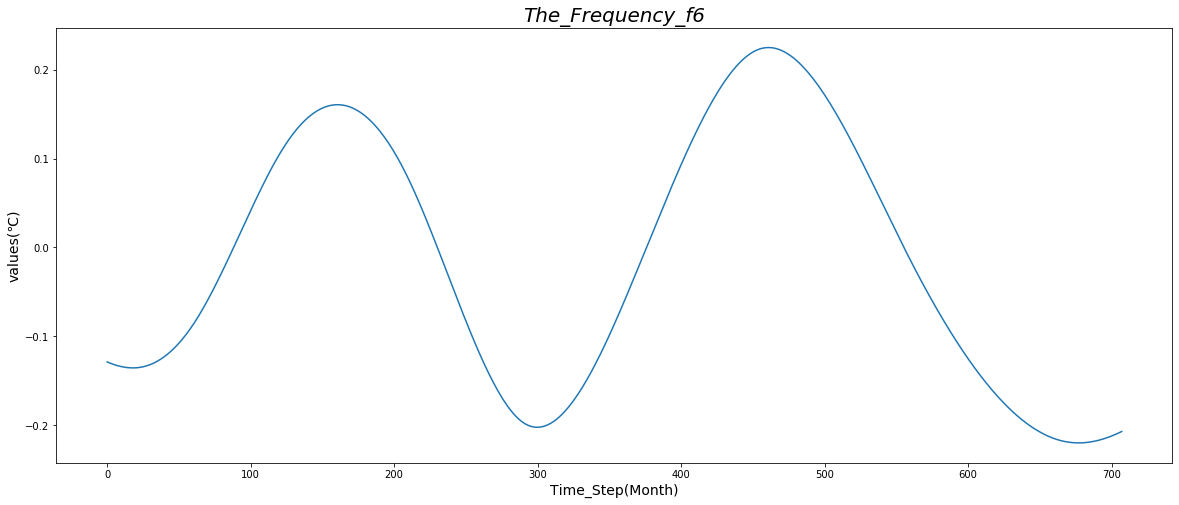

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 19s - loss: 0.0116
Epoch 2/200
 - 4s - loss: 0.0052
Epoch 3/200
 - 4s - loss: 0.0026
Epoch 4/200
 - 4s - loss: 0.0013
Epoch 5/200
 - 4s - loss: 5.1003e-04
Epoch 6/200
 - 4s - loss: 2.1040e-04
Epoch 7/200
 - 3s - loss: 8.6707e-05
Epoch 8/200
 - 3s - loss: 5.8920e-05
Epoch 9/200
 - 3s - loss: 3.3083e-05
Epoch 10/200
 - 3s - loss: 3.1919e-05
Epoch 11/200
 - 3s - loss: 5.5110e-05
Epoch 12/200
 - 3s - loss: 2.8447e-05
Epoch 13/200
 - 3s - loss: 1.7506e-05
Epoch 14/200
 - 4s - loss: 1.1234e-05
Epoch 15/200
 - 3s - loss: 1.0799e-05
Epoch 16/200
 - 3s - loss: 2.0864e-05
Epoch 17/200
 - 3s - loss: 2.4426e-05
Epoch 18/200
 - 3s - loss: 1.9740e-05
Epoch 19/200
 - 3s - loss: 1.3696e-05
Epoch 20/200
 - 3s - loss: 1.8922e-05
Epoch 21/200
 - 3s - loss: 2.3603e-05
Epoch 22/200
 - 3s - loss: 9.4653e-06
Epoch 23/200
 - 3s - loss: 1.0274e-05
Epoch 24/200
 - 3s - loss: 1.2975e-05
Epoch 25/200
 - 3s - loss: 1.8809e-05
Epoch 26/200
 - 3s - loss: 1.4158e-05
Epoch 27/200
 - 3s - loss: 1.3140e-0

(56, 12)


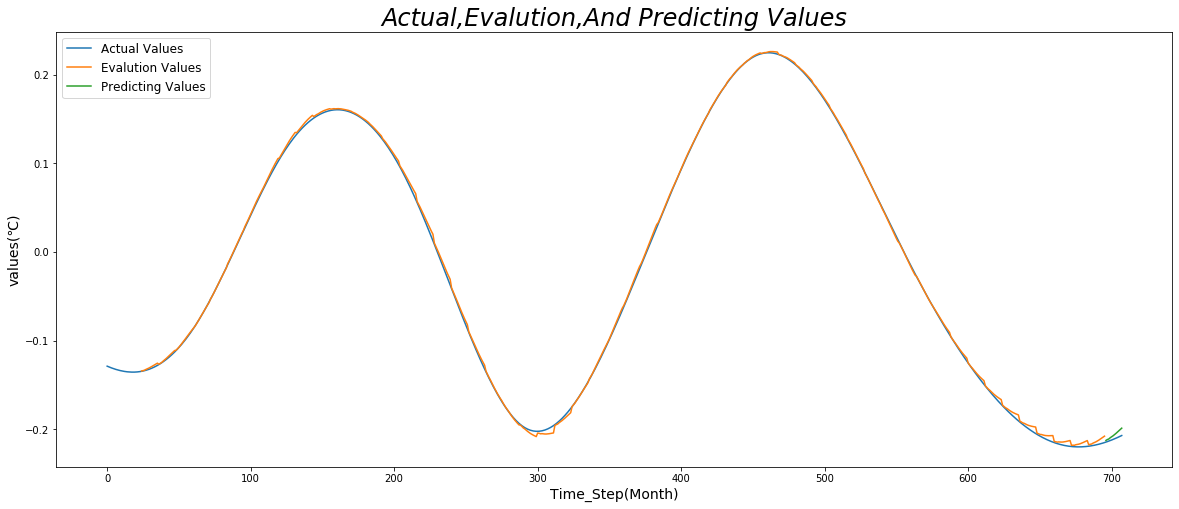

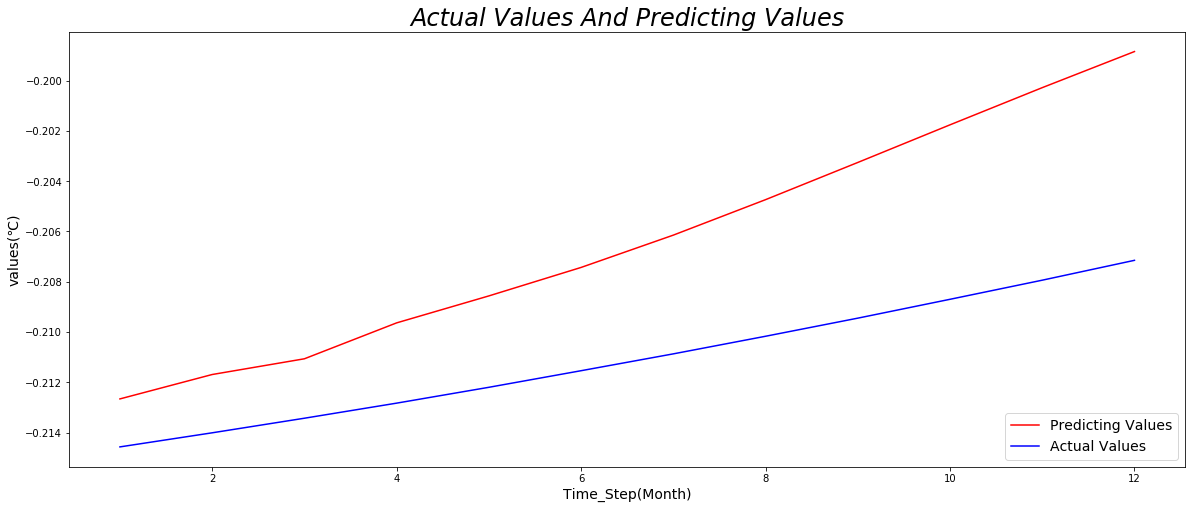

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
678    0.043380
679    0.043454
680    0.043525
681    0.043593
682    0.043657
683    0.043718
684    0.043776
685    0.043830
686    0.043882
687    0.043930
688    0.043975
689    0.044017
690    0.044056
691    0.044092
692    0.044124
693    0.044154
694    0.044180
695    0.044204
696    0.044224
697    0.044242
698    0.044256
699    0.044267
700    0.044276
701    0.044281
702    0.044283
703    0.044283
704    0.044279
705    0.044273
706    0.044263
707    0.044251
Name: f7, Length: 708, d

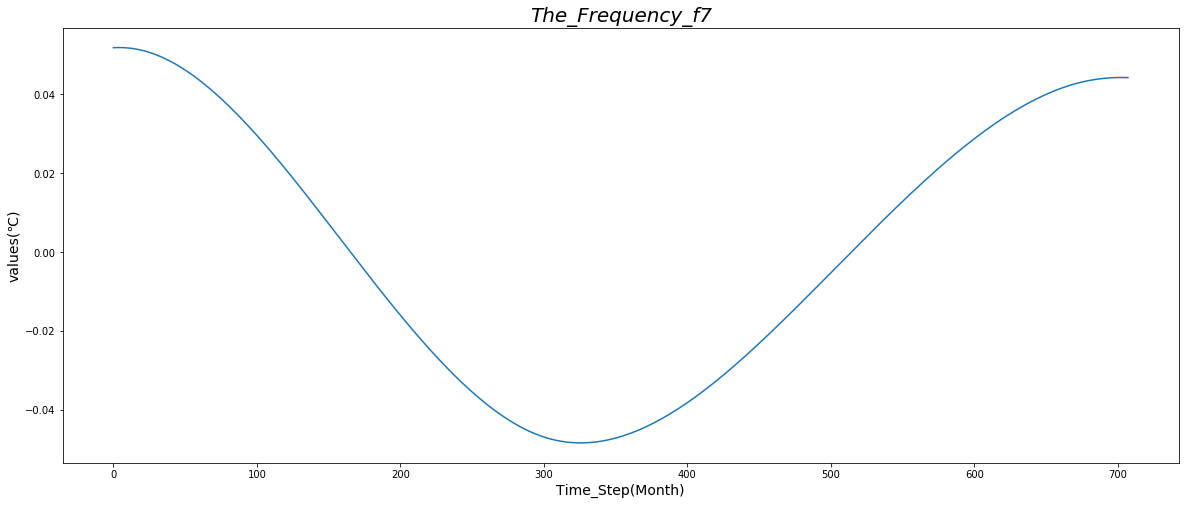

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 12s - loss: 7.9935e-04
Epoch 2/200
 - 4s - loss: 2.9073e-04
Epoch 3/200
 - 3s - loss: 1.3906e-04
Epoch 4/200
 - 3s - loss: 1.0747e-04
Epoch 5/200
 - 3s - loss: 8.0603e-05
Epoch 6/200
 - 4s - loss: 5.6916e-05
Epoch 7/200
 - 3s - loss: 4.7182e-05
Epoch 8/200
 - 3s - loss: 4.4733e-05
Epoch 9/200
 - 6s - loss: 3.6327e-05
Epoch 10/200
 - 6s - loss: 3.1083e-05
Epoch 11/200
 - 4s - loss: 3.1051e-05
Epoch 12/200
 - 4s - loss: 2.8346e-05
Epoch 13/200
 - 4s - loss: 2.7451e-05
Epoch 14/200
 - 4s - loss: 2.3227e-05
Epoch 15/200
 - 4s - loss: 3.5103e-05
Epoch 16/200
 - 4s - loss: 1.8057e-05
Epoch 17/200
 - 3s - loss: 1.5253e-05
Epoch 18/200
 - 3s - loss: 9.0963e-06
Epoch 19/200
 - 3s - loss: 9.5246e-06
Epoch 20/200
 - 3s - loss: 6.7499e-06
Epoch 21/200
 - 4s - loss: 6.0864e-06
Epoch 22/200
 - 3s - loss: 3.2855e-06
Epoch 23/200
 - 3s - loss: 1.0319e-06
Epoch 24/200
 - 3s - loss: 7.3034e-07
Epoch 25/200
 - 3s - loss: 1.2482e-06
Epoch 26/200
 - 3s - loss: 1.7596e-06
Epoch 27/200
 - 3s -

(56, 12)


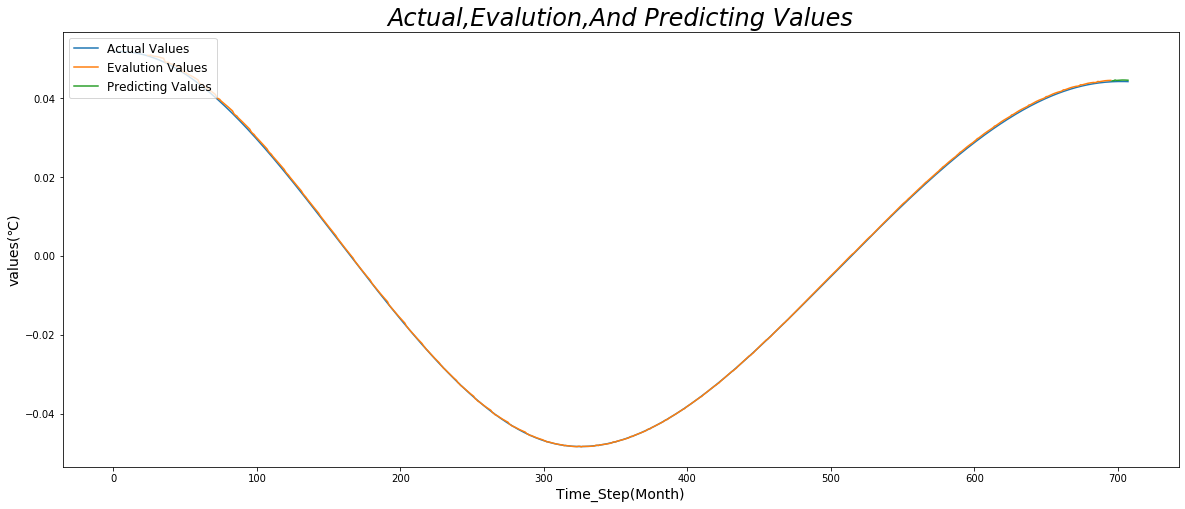

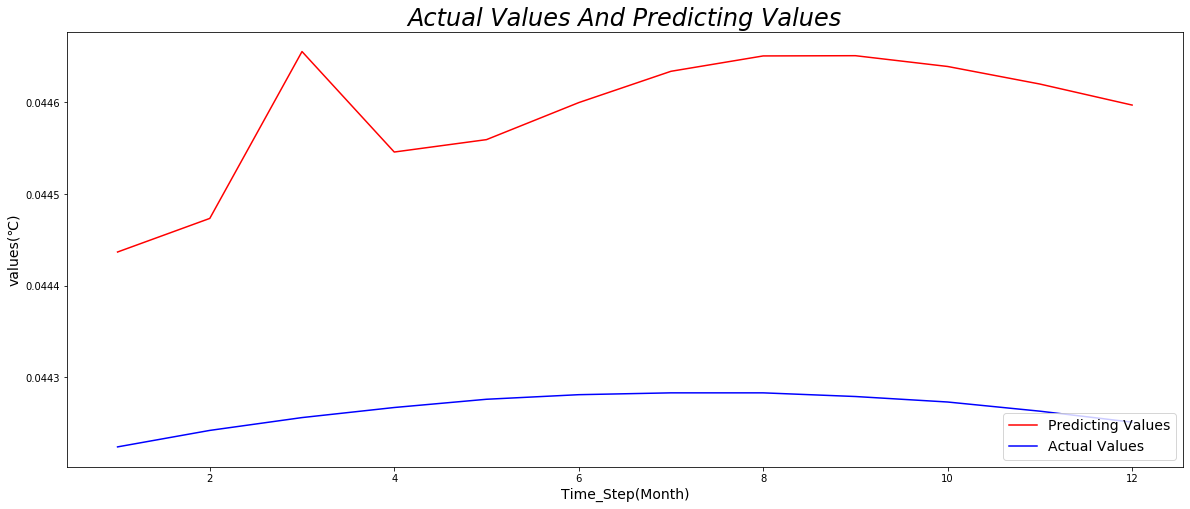

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
678    0.078349
679    0.078341
680    0.078334
681    0.078326
682    0.078318
683    0.078310
684    0.078302
685    0.078295
686    0.078287
687    0.078279
688    0.078272
689    0.078264
690    0.078256
691    0.078249
692    0.078241
693    0.078234
694    0.078226
695    0.078219
696    0.078212
697    0.078204
698    0.078197
699    0.078190
700    0.078182
701    0.078175
702    0.078168
703    0.078161
704    0.078154
705    0.078146
706    0.078139
707    0.078132
Name: f8, Length: 708, d

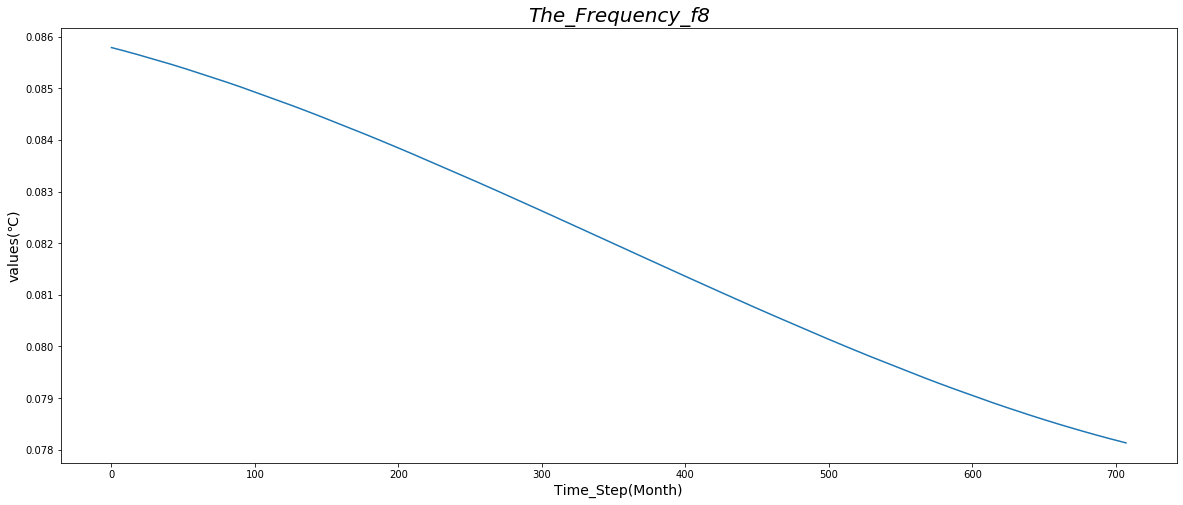

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 12s - loss: 6.3934e-04
Epoch 2/200
 - 3s - loss: 1.6108e-05
Epoch 3/200
 - 3s - loss: 6.7261e-06
Epoch 4/200
 - 3s - loss: 6.0658e-06
Epoch 5/200
 - 2s - loss: 5.4620e-06
Epoch 6/200
 - 4s - loss: 5.5791e-06
Epoch 7/200
 - 4s - loss: 5.4837e-06
Epoch 8/200
 - 4s - loss: 5.6178e-06
Epoch 9/200
 - 4s - loss: 5.3262e-06
Epoch 10/200
 - 3s - loss: 5.4435e-06
Epoch 11/200
 - 3s - loss: 5.2160e-06
Epoch 12/200
 - 3s - loss: 5.7416e-06
Epoch 13/200
 - 3s - loss: 5.7102e-06
Epoch 14/200
 - 3s - loss: 5.3970e-06
Epoch 15/200
 - 3s - loss: 5.7402e-06
Epoch 16/200
 - 3s - loss: 5.5880e-06
Epoch 17/200
 - 3s - loss: 5.4319e-06
Epoch 18/200
 - 3s - loss: 5.3994e-06
Epoch 19/200
 - 3s - loss: 5.9203e-06
Epoch 20/200
 - 3s - loss: 6.5223e-06
Epoch 21/200
 - 3s - loss: 5.2040e-06
Epoch 22/200
 - 3s - loss: 5.2939e-06
Epoch 23/200
 - 3s - loss: 5.6172e-06
Epoch 24/200
 - 3s - loss: 5.3989e-06
Epoch 25/200
 - 3s - loss: 5.1403e-06
Epoch 26/200
 - 3s - loss: 5.5132e-06
Epoch 27/200
 - 3s -

(56, 12)


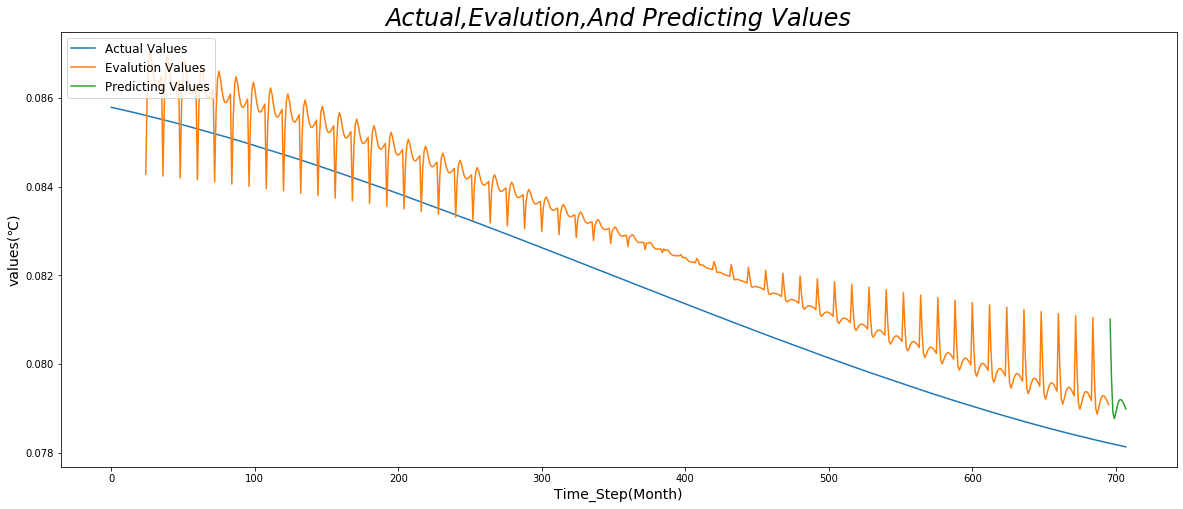

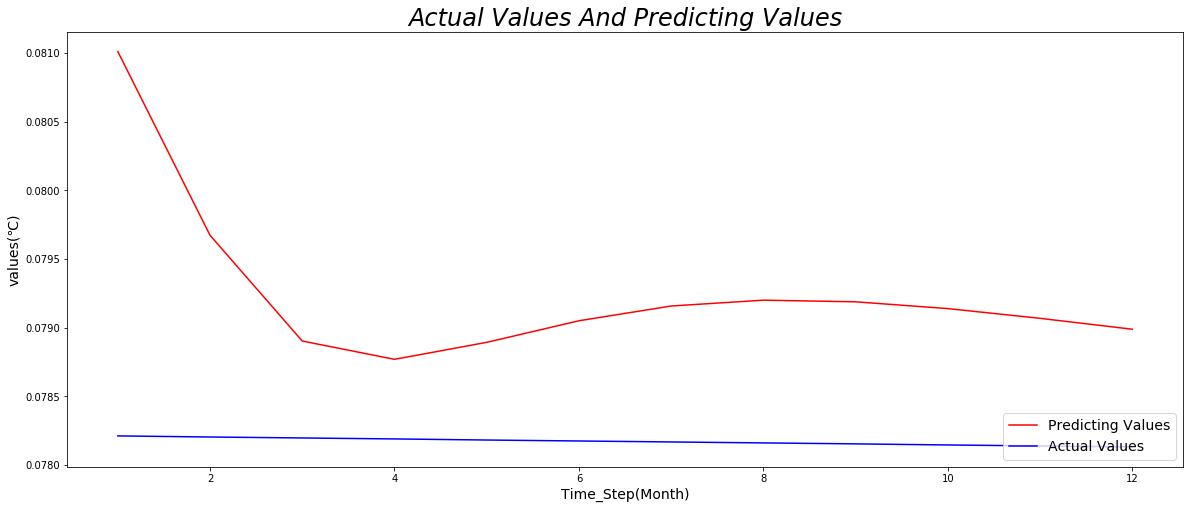

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-120]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08101068]
 [0.07967257]
 [0.07890285]
 [0.07876962]
 [0.07889326]
 [0.07905039]
 [0.07915781]
 [0.07920036]
 [0.07918842]
 [0.07913892]
 [0.07906805]
 [0.07898873]]
[array([-0.019294 ,  0.021388 , -0.028952 ,  0.038371 , -0.045308 ,
        0.046826 , -0.042584 , -0.030396 , -0.0018028,  0.018636 ,
       -0.016862 ,  0.022332 ]), array([-0.58173 , -0.37399 , -0.092222,  0.15317 ,  0.32912 ,  0.50709 ,
        0.64271 ,  0.65109 ,  0.517   ,  0.26965 , -0.037233, -0.32834 ]), array([-0.66973, -0.72969, -0.77339, -0.79891, -0.80437, -0.78789,
       -0.74749, -0.6812 , -0.5883 , -0.4732 , -0.34158, -0.19912]), array([-0.13697  , -0.11613  , -0.094459 , -0.072128 , -0.049296 ,
       -0.02613  , -0.0028679,  0.020229 ,  0.042903 ,  0.064891 ,
        0.085936 ,  0.10578  ]), array([ 0.049402 ,  0.037958 ,  0.026307 ,  0.014453 ,  0.0023977,
       -0.0098541, -0.0223   , -0.034936 , -0.047759 , -0.060765 ,
       -0.073953 , -0.087317 ]), array([-0.14955, -0.14796, -0.14631, -0.14459

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.019294   0.021388  -0.028952   0.038371  -0.045308   0.046826
 -0.042584  -0.030396  -0.0018028  0.018636  -0.016862   0.022332 ]
[[-0.019294 ]
 [ 0.021388 ]
 [-0.028952 ]
 [ 0.038371 ]
 [-0.045308 ]
 [ 0.046826 ]
 [-0.042584 ]
 [-0.030396 ]
 [-0.0018028]
 [ 0.018636 ]
 [-0.016862 ]
 [ 0.022332 ]]
[[-0.02]
 [ 0.02]
 [-0.03]
 [ 0.04]
 [-0.05]
 [ 0.05]
 [-0.04]
 [-0.03]
 [-0.  ]
 [ 0.02]
 [-0.02]
 [ 0.02]]
-----------------------------------
observe value:[-0.58173  -0.37399  -0.092222  0.15317   0.32912   0.50709   0.64271
  0.65109   0.517     0.26965  -0.037233 -0.32834 ]
[[-0.601024 ]
 [-0.352602 ]
 [-0.121174 ]
 [ 0.191541 ]
 [ 0.283812 ]
 [ 0.553916 ]
 [ 0.600126 ]
 [ 0.620694 ]
 [ 0.5151972]
 [ 0.288286 ]
 [-0.054095 ]
 [-0.306008 ]]
[[-0.6 ]
 [-0.35]
 [-0.12]
 [ 0.19]
 [ 0.28]
 [ 0.55]
 [ 0.6 ]
 [ 0.62]
 [ 0.52]
 [ 0.29]
 [-0.05]
 [-0.31]]
-----------------------------------
observe value:[-0.66973 -0.72969 -0.77339 -0.79891 -0.80437 -0.78789 -0.74749 -0.6812
 -

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.0082133  -0.00131945  0.05858952  0.05472736 -0.04529786 -0.13077843
 -0.07452939  0.07591751  0.14736219  0.03666651 -0.16025119 -0.199159  ]
[-0.0082133  -0.00131945  0.05858952  0.05472736 -0.04529786 -0.13077843
 -0.07452939  0.07591751  0.14736219  0.03666651 -0.16025119 -0.199159  ]
the 1 frequence:
predicted_value:[-0.64743316 -0.5046262  -0.25508556  0.03154307  0.30898732  0.55306935
  0.73264515  0.8320935   0.8472978   0.78036034  0.63906157  0.43808672]
[-0.65564646 -0.50594566 -0.19649604  0.08627043  0.26368946  0.42229092
  0.65811576  0.90801099  0.99465998  0.81702685  0.47881038  0.23892772]
the 2 frequence:
predicted_value:[-0.63077724 -0.6534125  -0.64625686 -0.61712223 -0.5766749  -0.5421836
 -0.52292925 -0.5209587  -0.5315131  -0.5468101  -0.55976456 -0.5654668 ]
[-1.2864237  -1.15935818 -0.8427529  -0.5308518  -0.31298542 -0.11989266
  0.13518651  0.38705227  0.46314688  0.27021676 -0.0809

[[-1.6]
 [-1.4]
 [-1.2]
 [-0.9]
 [-0.8]
 [-0.5]
 [-0.4]
 [-0.3]
 [-0.3]
 [-0.4]
 [-0.6]
 [-0.7]]
[-1.59580449 -1.46228181 -1.14060985 -0.82203713 -0.59709808 -0.39691148
 -0.13518662  0.1228393   0.20460761  0.01647797 -0.33169975 -0.57737911]


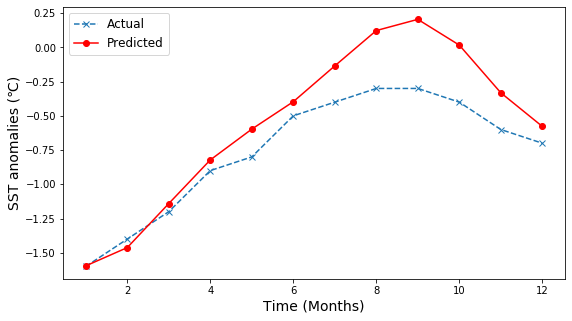

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
